# Introduction
The goal of this notebook is to show how to obtain the basic DataFrames with the transmitted power data used in "Regression-Based Law of Energy Efficiency in Wireless Sensor Networks", submitted at the CBA 2024. 

The trasmitted power was calculated according two clustering methods, K-Means and grid-based clustering.


We created two functions based on this notebook to provide the data used in the regression analysis

# Importing packages and classes

In [1]:
#importing the basic packages used in this experiment
import numpy as np   #package used to vectorize the created data
import matplotlib.pyplot as plt #package/module to do and edit graphs/plots
import pandas as pd #package to manage data in tabular/relational fashion
import seaborn as sns #package to create plots/graphs
from sklearn.cluster import KMeans #class to instanciate the Kmeans algorithm
from sklearn.preprocessing import OrdinalEncoder #class to instaciate labels for the grid method
pd.options.mode.chained_assignment = None # remove warnings outputs from pandas package

In [2]:
#importing the resource to control the generation of pseudo-random numbers
#a resource to create seeds and make data drawing reproducible
from numpy.random import default_rng

In [3]:
# defining the seed that will control the generation of pseudo-randoms, to guarantee the reproducibility of results and comparisons
gera = default_rng(seed = 24)

## Setting the parameters of the experiment

In [4]:
# side of the experiment area (in meters)
L = 200

# number of nodes
N_node = 140

# array with the grid partitions data
# here, we have 3 horizontal partitions and 2 vertical pratitions 
N_grid = np.array([3,2]) 

# number of clusters
# here, we have 3 times 2 = 6 clusters
N_cluster = N_grid.prod()

#number of experimental realizations conducted
N_realiz = 100



# creating tables for the data

## node and cluster labeling data

In [ ]:
# generating the coordinates of the 140 nodes
# we use the uniform function from the numpy package to generate random data with uniform distribution
coord_nos = gera.uniform(0,L, size=(N_node,2,N_realiz))


In [5]:
# creating a list of tables with the node coordinates. The list is over the number of realizations

df_kmeans = [pd.DataFrame({'x':coord_nos[:,0,i],'y':coord_nos[:,1,i]}) for i in range(N_realiz)] # table for K-Means results
df_grid = [pd.DataFrame({'x':coord_nos[:,0,i],'y':coord_nos[:,1,i]}) for i in range(N_realiz)]  # table for Grid Method results

In [6]:
# create a list of instances to implement the K-Means clusterization (over the number of realizations)
kmeans = [KMeans(n_clusters=N_cluster, n_init=20) for i in range(N_realiz)] 

# training and clustering the refered list of instances of K-Means 
y_pred = [kmeans[i].fit_predict(df_kmeans[i][['x','y']]) for i in range(N_realiz)] #as predições de cada nó segundo o Kmeans 

In [7]:
# inserting the clusterization outputs to the K-Means table
for i in range(N_realiz):
    df_kmeans[i]['label'] = y_pred[i]


In [8]:
# creating the instance to do labels for the grid method
encode = OrdinalEncoder()

#creating a list composed by horizontal e vertical partition label of grid method 
gride_code = [np.int32(np.ceil(df_grid[i][["x","y"]]*(N_grid/L))).astype(str) for i in range(N_realiz)]

#creating a label with similar information of above list
for j in range(N_realiz):
    df_grid[j]['label'] = [''.join(gride_code[j].tolist()[i]) for i in range(N_node)]

#creating the final label
for j in range(N_realiz):
    df_grid[j]['label'] = encode.fit_transform(np.array(df_grid[j]['label']).reshape(-1,1)).astype(int)

## visualizing the clusterizations according to K-Means and Grid Method

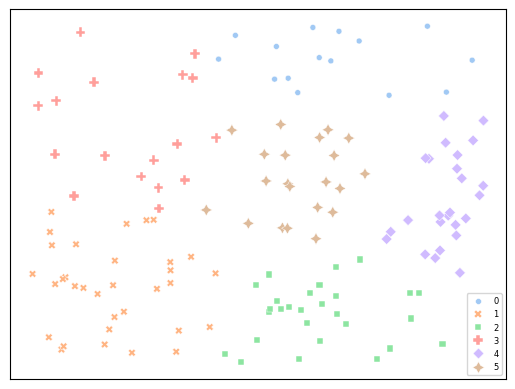

In [9]:
sns.scatterplot(data = df_kmeans[4], x = 'x', y = 'y', hue = 'label', style = 'label', size= 'label', palette=sns.color_palette("pastel",N_cluster))
plt.legend(fontsize = 6)
plt.xticks([], [])
plt.yticks([],[])
plt.xlabel("")
plt.ylabel("")
plt.savefig('kmeans_example.png', bbox_inches='tight')

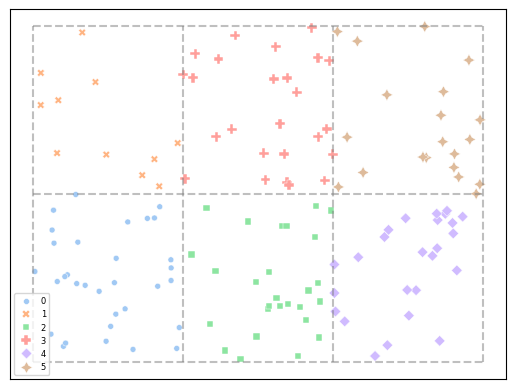

In [10]:
sns.scatterplot(data = df_grid[4], x = 'x', y = 'y', hue = 'label' , style = 'label', size= 'label', palette=sns.color_palette("pastel",N_cluster))
plt.hlines(100,0,200,linestyles='dashed',colors='grey', alpha= 0.5)
plt.hlines(0,0,200,linestyles='dashed',colors='grey', alpha= 0.5)
plt.hlines(200,0,200,linestyles='dashed',colors='grey', alpha= 0.5)
plt.vlines(66.66,0, 200,linestyles='dashed',color='grey', alpha = 0.5)
plt.vlines(133.33,0 , 200,linestyles='dashed',color = 'grey', alpha = 0.5)
plt.vlines(0,0, 200,linestyles='dashed',color='grey', alpha = 0.5)
plt.vlines(200,0, 200,linestyles='dashed',color='grey', alpha = 0.5)
plt.legend(fontsize=6)
plt.xticks([], [])
plt.yticks([],[])
plt.xlabel("")
plt.ylabel("")
plt.savefig('grid_example.png', bbox_inches='tight')

In [11]:
# list of the K-Means centroid coordinates (over the number of realizations)
centroid_kmeans = [kmeans[i].cluster_centers_ for i in range(N_realiz)]

# centroid coordinates for grid method
grid_index =[np.array([[i,j]for i in range(1,N_grid[0]+1)for j in range(1,N_grid[1]+1)])for k in range(N_realiz)]
centroid_grid = [(grid_index[i] - 0.5) * (L/N_grid) for i in range(N_realiz)]

In [12]:
# calculating (and inserting to table) the distance from the centroid to the node for each realization (K-Means)
for i in range(N_realiz):
    dif = np.linalg.norm(centroid_kmeans[i][df_kmeans[i]['label']]- np.array(df_kmeans[i][['x','y']]), axis = 1)
    df_kmeans[i]['c_to_node'] = dif

In [13]:
# calculating (and inserting to table) the distance from the "centroid" of the grid to the node for each realization
for i in range(N_realiz):
    dif = np.linalg.norm(centroid_grid[i][df_grid[i]['label']]- np.array(df_grid[i][['x','y']]), axis = 1)
    df_grid[i]['c_to_node'] = dif

In [14]:
# inserting the centroids to the table
for i in range(N_realiz):
    df_kmeans[i]['x_centroid']=centroid_kmeans[i][df_kmeans[i]['label']][:,0]
    df_kmeans[i]['y_centroid']=centroid_kmeans[i][df_kmeans[i]['label']][:,1]

In [15]:
# inserting the centroids to the table
for i in range(N_realiz):
    df_grid[i]['x_centroid']=centroid_grid[i][df_grid[i]['label']][:,0]
    df_grid[i]['y_centroid']=centroid_grid[i][df_grid[i]['label']][:,1]

In [16]:
### finding the indices of the closest nodes

In [17]:
indice_kmeans = [[df_kmeans[j][df_kmeans[j]['label'] == i]['c_to_node'].idxmin() for i in range(N_cluster)] for j in range(N_realiz)]
indice_grid = [[df_grid[j][df_grid[j]['label'] == i]['c_to_node'].idxmin() for i in range(N_cluster)] for j in range(N_realiz)]

### breaking down the data into tables for each realization and cluster

In [18]:
df_rc_kmeans = [[df_kmeans[j][df_kmeans[j]['label']==i] for i in range(N_cluster)] for j in range(N_realiz)]
df_rc_grid = [[df_grid[j][df_grid[j]['label']==i] for i in range(N_cluster)] for j in range(N_realiz)]

In [19]:
# inserting head coordinate columns into DataFrames for each realization and each clusterfor j in range(N_realiz):
for j in range(N_realiz):
    for i in range(N_cluster):
            df_rc_kmeans[j][i]['x_head'] = df_rc_kmeans[j][i].loc[indice_kmeans[j][i]][0]
            df_rc_kmeans[j][i]['y_head'] = df_rc_kmeans[j][i].loc[indice_kmeans[j][i]][1]

In [20]:
# inserting head coordinate columns into DataFrames for each realization and each clusterfor j in range(N_realiz):
for j in range(N_realiz):
    for i in range(N_cluster):
            df_rc_grid[j][i]['x_head'] = df_rc_grid[j][i].loc[indice_grid[j][i]][0]
            df_rc_grid[j][i]['y_head'] = df_rc_grid[j][i].loc[indice_grid[j][i]][1]

In [23]:
#calculating and inserting to the tables the distances between head to nodes
for j in range(N_realiz):
    for i in range(N_cluster):
        dif_k = np.array(df_rc_kmeans[j][i][['x_head','y_head']])- np.array(df_rc_kmeans[j][i][['x','y']])
        df_rc_kmeans[j][i]['h_to_node'] = np.linalg.norm(dif_k, axis = 1)
        dif_g = np.array(df_rc_grid[j][i][['x_head','y_head']])- np.array(df_rc_grid[j][i][['x','y']])
        df_rc_grid[j][i]['h_to_node'] = np.linalg.norm(dif_g, axis = 1)

In [ ]:
# exclude the head node to the data
# the table df_rc_kmeans_no_head exclude the head node and the table df_rc_kmeans_heads has the head node line
df_rc_kmeans_no_head = [[df_rc_kmeans[j][i][df_rc_kmeans[j][i]['x'] != df_rc_kmeans[j][i].loc[indice_kmeans[j][i]][0]] for i in range(N_cluster)] for j in range(N_realiz)]
df_rc_kmeans_heads = [[df_rc_kmeans[j][i][df_rc_kmeans[j][i]['x'] == df_rc_kmeans[j][i].loc[indice_kmeans[j][i]][0]] for i in range(N_cluster)] for j in range(N_realiz)]

In [ ]:
#calculate the distances between head node and base station (sink) and inserting it in the table
for j in range(N_realiz):
    for i in range(N_cluster):
        dife_k = np.array(df_rc_kmeans_heads[j][i][['x_head','y_head']])- np.array([L,L])
        df_rc_kmeans_heads[j][i]['h_to_sink'] = np.linalg.norm(dife_k, axis = 1)


In [ ]:
# exclude the head node to the data
# the table df_rc_grid_no_head exclude the head node and the table df_rc_grid_heads has the head node line
df_rc_grid_no_head = [[df_rc_grid[j][i][df_rc_grid[j][i]['x'] != df_rc_grid[j][i].loc[indice_grid[j][i]][0]] for i in range(N_cluster)] for j in range(N_realiz)]
df_rc_grid_heads = [[df_rc_grid[j][i][df_rc_grid[j][i]['x'] == df_rc_grid[j][i].loc[indice_grid[j][i]][0]] for i in range(N_cluster)] for j in range(N_realiz)]

In [ ]:
#calculate the distances between head node and base station (sink) and inserting it in the table
for j in range(N_realiz):
    for i in range(N_cluster):
        dife_g = np.array(df_rc_grid_heads[j][i][['x_head','y_head']])- np.array([L,L])
        df_rc_grid_heads[j][i]['h_to_sink'] = np.linalg.norm(dife_g, axis = 1)


## creating the transmitted power data

To do so, we must:
* calculate the constant  $k = (\frac{4 \pi}{\lambda})² P_r$,
* where
* $P_r$ is the power received by the head node (constant $-70$ milli decibels).

* square the distances (which are in the "h_to_node" column)



In [ ]:
# speed of light
c = 299792458.0
freq = 2.4 * 10**9
P_r = 0.0000001 # convert -70 thousand decibels into milliwatts
comprimento = c / freq
k = P_r *((4 * np.pi)/comprimento)**2 

In [ ]:
# transmitted power from nodes to head  
for j in range(N_realiz):
    for i in range(N_cluster):
        df_rc_grid_no_head[j][i]['P_t'] = k * (df_rc_grid_no_head[j][i]['h_to_node']**2)
        df_rc_kmeans_no_head[j][i]['P_t'] = k * (df_rc_kmeans_no_head[j][i]['h_to_node']**2)

In [ ]:
# transmitted power from head to base station (sink)
for j in range(N_realiz):
    for i in range(N_cluster):
        df_rc_grid_heads[j][i]['P_t'] = k * (df_rc_grid_heads[j][i]['h_to_sink']**2)
        df_rc_kmeans_heads[j][i]['P_t'] = k * (df_rc_kmeans_heads[j][i]['h_to_sink']**2)